In [55]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from sklearn.metrics import explained_variance_score

In [2]:
def data_load(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    y_tmp = lines[0].split(',')
    y = [float(i) for i in y_tmp]
    x_tmp = lines[1].split(',')
    x = [float(i) for i in x_tmp]
    
    return [x, y]

In [3]:
def do_go(x_training, y_training, kernel):
    X = np.array(x_training).reshape(-1, 1)
    # Observations
    y = y_training
    
    #for prediction
    x = np.linspace(-237, -207, 100).reshape(-1,1)

    # Instantiate a Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)
    print(np.min(y_pred))
    print(x[np.argmin(y_pred)])

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure(figsize=(10,5))
    plt.plot(X, y, 'r.', markersize=10, label='Observations')
    plt.plot(x, y_pred, 'b-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    #plt.fill(np.concatenate([x, x[::-1]]),
    #         np.concatenate([y_pred - 2.5760 * sigma,
    #                        (y_pred + 2.5760 * sigma)[::-1]]),
    #         alpha=.3, fc='g', ec='None', label='99% confidence interval')
    plt.xlabel('$x-position$')
    plt.ylabel('$min. distance$')
    plt.ylim(-10, 20)
    plt.legend(loc='upper left')
    plt.show
    return [x, y_pred, sigma]

In [4]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

In [66]:
def train_gp(count, x_train, x, y_train):
    X = np.array(x_train).reshape(-1, 1)
    kernel = RBF(10-(count/2), (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=70)
    gp.fit(X, y_train)
    y_pred, sigma = gp.predict(x, return_std=True)
    return [y_pred, sigma, gp]

In [179]:
def plot_gp(x_train, y_train, x, y_pred, sigma, x1, y1):
    plt.figure(figsize=(10,5))
    plt.plot(x_train, y_train, 'r.', markersize=10, label='Observations')
    plt.plot(x, y_pred, 'b-', label='Prediction')
    plt.fill_between(np.linspace(-240, -206, 200), y_pred - 1.9600 * np.abs(sigma), y_pred + 1.9600 * np.abs(sigma),
                      color='b', alpha=0.5)
    plt.plot(x1, y1, color='k', label='Original data')
    plt.show()


In [180]:
def acquisition_func(data_x, x, sigma, y_pred):
    
    sigma_score = sigma/sigma[np.argmax(sigma)] * 0.6
    #print('sigma max: ' + str(sigma[np.argmax(sigma)]) + ' at idx ' + str(x[np.argmax(sigma)]))
    
    distance_score = (1 - y_pred/y_pred[np.argmax(y_pred)]) * 0.4
    
    end_score = sigma_score + distance_score
    #print(end_score)
    #print(sigma_score[np.argmax(end_score)])
    #print(distance_score[np.argmax(end_score)])
    
    #min_val = min(enumerate(data_x), key=lambda l: abs(l[1]-x[np.argmax(end_score)]))
    best_val = np.argmax(end_score)
    #print(min_val)
    return best_val

In [181]:
def end_condition_reached(sigma, x_train, y1, y_pred_plot):
    #end = np.abs(sigma[np.argmax(sigma)])*1.96 < 0.3 or len(x_train) > 15 or np.abs(y1[np.argmin(y1)] - y_pred_plot[np.argmin(y_pred_plot)]) < 0.1 
    end = len(x_train) > 15 or np.abs(y1[np.argmin(y1)] - y_pred_plot[np.argmin(y_pred_plot)]) < 0.1 
    return end

Round 1


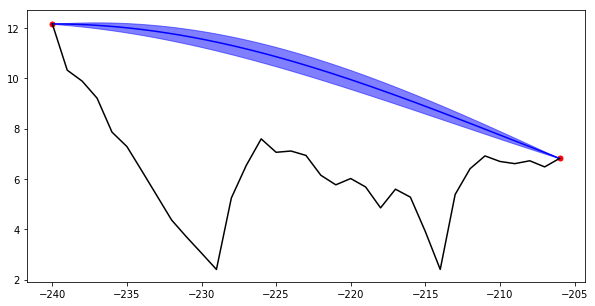

Round 2


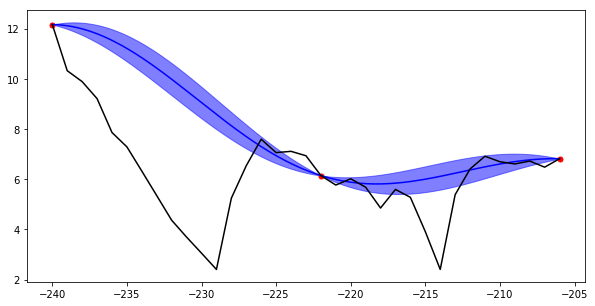

Round 3


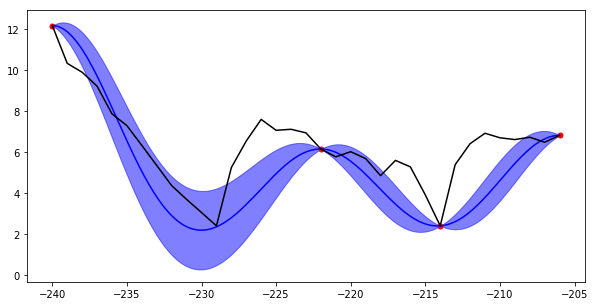

Round 4


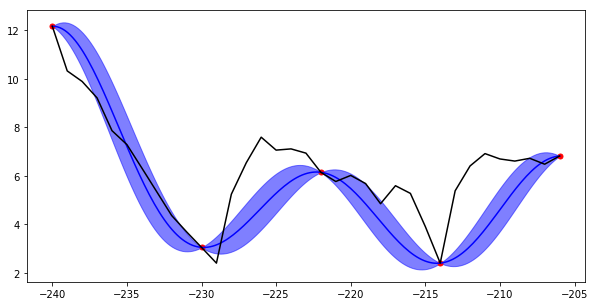

In [182]:
# prepare data
[x1, y1] = data_load('../../git/scenario_runner/data4.txt')
x = np.linspace(-240, -206, 200).reshape(-1,1)

x_train = []
x_train.append(x1[0])
x_train.append(x1[34])

y_train = []
y_train.append(y1[0])
y_train.append(y1[34])

#y_pred, sigma, gp = train_gp(0, x_train, x, y_train)

end = False
count = 0
while(not end):
    print('Round ' + str(count + 1))
    
    # get new interation
    y_pred, sigma, gp = train_gp(count, x_train, x, y_train)
    
    y_pred_plot, sigma_pred = gp.predict(np.array(x1).reshape(-1, 1), return_std=True)
    
    # plot data
    plot_gp(x_train, y_train, x, y_pred, sigma, x1, y1)

    end = end_condition_reached(sigma, x_train, y1, y_pred)
    if not end:
        count += 1

        # add new data point to list
        best_val = acquisition_func(x1, x, sigma_pred, y_pred_plot)
        x_train.append(x1[best_val])
        y_train.append(y1[best_val])